In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [111]:
train = pd.read_csv('training_new.csv')
# test = pd.read_csv('challenge_data.csv')

In [112]:
# train = train.drop('Ops Mode',axis = 1)

In [113]:
TRA = train['TRA']
OpsMode = []
for x in TRA:
#     if x == 0:
#         OpsMode.append(1)
#     if x == 20:
#         OpsMode.append(2)
#     if x == 40:
#         OpsMode.append(3)
#     if x == 60:
#         OpsMode.append(4)
#     if x == 80:
#         OpsMode.append(5)
#     if x == 100:
#         OpsMode.append(6)
    if x == 60:
        OpsMode.append(1)
    if x == 100:
        OpsMode.append(2)
    


In [114]:
train['OpsMode'] = OpsMode
train = train.drop(['Altitude','Mach No','TRA'],axis=1)

In [115]:
unitlife = []
n = train['A/C'].nunique()

In [116]:
for i in range(1,n+1):
    k = train[train['A/C'] == i].shape[0]
    unitlife += k*[k]

In [117]:
train['unitlife'] = unitlife
train['Time'] = train['Time']-train['unitlife']
train = train.drop('unitlife',axis = 1)

In [118]:
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler,StandardScaler
%matplotlib inline

In [119]:
cols = ['T2','P2','P15','Nf','Nc','EPR','NRf','Nrc','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']
train = train.drop(cols,axis = 1)
# test = test.drop(cols,axis = 1)

In [120]:
X = train[(train['Time']<-300) | (train['Time']>-5)]
X = X.drop('A/C',axis = 1)

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [122]:
scaler = MinMaxScaler()
M = []
score = []
# for i in range (1,7):
for i in range (1,3):
    Xi = X[X['OpsMode'] == i]
    
    Xi = Xi.drop('OpsMode',axis=1)
#     print(Xi.shape[0])
    yi = np.where(Xi['Time']>-5,0,1)
    Time = Xi['Time']
    Xi = Xi.drop('Time',axis=1)
    scaler.fit(Xi)
    Xi = scaler.transform(Xi)
    Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi, test_size=0.2, random_state=0)
    regressor = LinearRegression()
    Mi = regressor.fit(Xi_train,yi_train)
    yi_pred = Mi.predict(Xi_test)
    score.append(r2_score(yi_test,yi_pred))
    coeff_df = pd.DataFrame(Mi.coef_, columns = ['Coefficient'])
#     print(coeff_df)
    M.append(Mi)

In [124]:

scaler = MinMaxScaler()
data = []
# for i in range(1,7):
for i in range (1,3):
    Xi = train[train['OpsMode'] == i]
    Xii = Xi.drop(['A/C','OpsMode','Time'],axis = 1)
    Xi = Xi.drop(['T24','T30','T50','P30','Ps30','phi','BPR','OpsMode'],axis = 1)
    scaler.fit(Xii)
    Xii = scaler.transform(Xii)
    yi = M[i-1].predict(Xii)
    Xi['HI'] = yi
    data.append(Xi)

In [125]:
df = pd.concat(data)
df.sort_index(inplace = True)

[-0.29686316  0.01389891  1.09184468  0.03981709]
[[-3.60771576e+10 -5.50955036e+00 -1.21527902e+11 -5.46259268e+02]
 [-5.50955732e+00  1.18502778e-06 -1.85592431e+01 -2.16108767e-05]
 [-1.21527902e+11 -1.85592236e+01 -4.09373465e+11 -1.84010523e+03]
 [-5.46258983e+02 -2.16108765e-05 -1.84010427e+03  7.83016095e-04]]


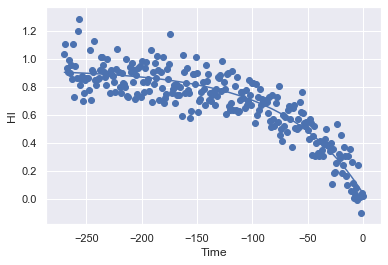

In [127]:
d = df[df['A/C']==11]
from scipy.optimize import curve_fit
def func(x,a,b,c,d):
    return a*(np.exp(b*x+c)-np.exp(c))+d
x = np.array(d['Time'])
y = d['HI']
popt, pcov = curve_fit(func,x,y,absolute_sigma=False)
plt.plot(x,func(x,*popt))
plt.ylabel('HI')
plt.xlabel('Time')
plt.scatter(x,y)
print(popt)
print(pcov)

In [128]:
from scipy.optimize import curve_fit
def func(x,a,b,c,d):
    return a*(np.exp(b*x+c)-np.exp(c))+d
def func1(x,a,b,c):
    return a*(np.exp(b*x+c)-np.exp(c))
fitted_curve_parameters = []
covariance = []
var = 0
for i in range(1,n+1):
    data = df[df['A/C'] == i]
    x = np.array(data['Time'])
    y = np.array(data['HI'])
    popt, pcov = curve_fit(func,x,y)
    
    var = 0
    for j in range(4):
        var = var + pcov[j][j]*pcov[j][j]
#     if(var == float('inf')) :
#         popt, pcov = curve_fit(func1,x,y)
#         var = 0
#         for j in range(3):
#             var = var+pcov[j][j]*pcov[j][j]
            
    fitted_curve_parameters.append(popt)        
    covariance.append(var)
#some of the units do not have optimised parameters we will have to discard those units
# print(popt)
# print(pcov)

/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


In [129]:
len(covariance)


260

In [130]:
test = pd.read_csv('testing_new.csv')

In [131]:
test_data = test
cols = ['T2','P2','P15','Nf','Nc','EPR','NRf','Nrc','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']
test_data = test_data.drop(cols,axis = 1)

In [132]:
TRA1 = test_data['TRA']
OpsMode1 = []
for x in TRA1:
#     if (x == 0 or x == '0'):
#         OpsMode1.append(1)
#     if (x == 20 or x == '20'):
#         OpsMode1.append(2)
#     if (x == 40 or x == '40'):
#         OpsMode1.append(3)
#     if (x == 60 or x == '60'):
#         OpsMode1.append(4)
#     if (x == 80 or x == '80'):
#         OpsMode1.append(5)
#     if (x == 100 or x == '100'):
#         OpsMode1.append(6)
#     if x == 'TRA' :
#         OpsMode1.append(-1)
    if x == 60:
        OpsMode1.append(1)
    if x == 100:
        OpsMode1.append(2)
    

In [133]:
test_data['OpsMode'] = OpsMode1
test_data = test_data[test_data.OpsMode != -1]
test_data = test_data.drop(['Altitude','Mach No','TRA'],axis=1)

In [134]:
p = test_data['A/C']
p.describe()
#the account no have values like 30, '30' so the two must be considered seperately

count    33991.000000
mean       127.528346
std         74.144727
min          1.000000
25%         65.000000
50%        128.000000
75%        189.000000
max        259.000000
Name: A/C, dtype: float64

In [135]:
scaler = MinMaxScaler()
data = []
# for i in range(1,7):
for i in range(1,3):
    Xi = test_data[test_data['OpsMode'] == i]
    Xii = Xi.drop(['A/C','OpsMode','Time'],axis = 1)
    Xi = Xi.drop(['T24','T30','T50','P30','Ps30','phi','BPR','OpsMode'],axis = 1)
    scaler.fit(Xii)
    Xii = scaler.transform(Xii)
    yi = M[i-1].predict(Xii)
    Xi['HI'] = yi
    data.append(Xi)

In [136]:
df_test = pd.concat(data)
df_test.sort_index(inplace = True)

In [137]:
num = df_test['A/C'].max()
#stores number of aircrafts

In [138]:
def get(x,a,b,c,d):
    return a*(np.exp(b*x+c)-np.exp(c))+d 
index = 0
RUL_final = []
for t in range(num):
    data1 = df_test[df_test['A/C'] == (t+1)]
    
    HI = data1['HI']
    RUL_list = []
    Dis_list = []
    for j in range (210):
        RUL = -1
        Dis = -1
        n = df[df['A/C'] == j].shape[0]
        r = data1.shape[0]
        k = n-r+1
        if(k > 0):
            if (covariance[j] != float('inf')):
                for tou in range(k):

                    #only for Tou =0 and M1 that is model obtained from unit1
                    s = 0
                    a = fitted_curve_parameters[j][0]
                    b = fitted_curve_parameters[j][1]
                    c = fitted_curve_parameters[j][2]
                    d = fitted_curve_parameters[j][3]
                    for i in range (r):
                        y = HI[i+index]
                        p = get(i-r-tou,a,b,c,d)
                        s = s+(y-p)*(y-p)
                    dis = s/covariance[j]
                    rul = r+tou
                    if(Dis == -1):
                        Dis = dis
                        RUL = rul
                    else:
                        if(Dis > dis):
                            Dis = dis
                            RUL = rul
                    #store the RUL and dis for the min dis-Tou in list dist
                    # how to get the RUL from the stored model for a given tou?
                #store the dist for each model
        if(Dis != -1):
            RUL_list.append(RUL)
            Dis_list.append(Dis)
    p = []
    p.append(RUL_list)
    p.append(Dis_list)
    df1 = pd.DataFrame(p,index = ['RUL','Dis']).T
    df1 = df1.sort_values(['Dis'])
    x = len(p[0])
    idx = []
    for i in range(x):
        idx.append(i)


    df1.index = idx
    x = (int)(x/4)
    RUL_obtained = df1['RUL']
    RUL_estimated = 0
    for i in range (x):
        RUL_estimated = RUL_estimated+RUL_obtained[i]
    RUL_estimated = RUL_estimated/(x+1)
    RUL_final.append(RUL_estimated)  
    index = index+r

In [72]:

# df1 stores the estimated rul from all the training models with their 

164.14893617021278

46